# ShapeNet dataset

We explore a subset of the [Shapenet-core](https://www.kaggle.com/datasets/jeremy26/shapenet-core) dataset and run some experiments. This version of the dataset only contains point clouds, so among other things, we try some remeshing procedure. However, even after applying some smoothing techniques, the qualiy of the results is pretty poor.  
In theory this shouldnn't be an issue as the paper claims to be representation agnoctic. But the poor generalization results we obtained would suggest that the model might not be that robust. *however this is just an hypothesis and further experiments must be run to validate it or not*.

In [1]:
import os
import json
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import meshplot as m
import potpourri3d as pp
import pymeshlab

import kagglehub

### Loading the data

In [2]:
root = kagglehub.dataset_download("jeremy26/shapenet-core")
dataset_name = 'Shapenetcore_benchmark'
print("Path to dataset files:", root)

def cat2idx(file_path):
    categories = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(maxsplit=1)
            categories[key] = value
    return categories

cat = cat2idx(os.path.join(root, dataset_name, 'synsetoffset2category.txt'))
cat

Path to dataset files: /home/infres/lmartinez-21/.cache/kagglehub/datasets/jeremy26/shapenet-core/versions/1


{'Airplane': '02691156',
 'Bag': '02773838',
 'Cap': '02954340',
 'Car': '02958343',
 'Chair': '03001627',
 'Earphone': '03261776',
 'Guitar': '03467517',
 'Knife': '03624134',
 'Lamp': '03636649',
 'Laptop': '03642806',
 'Motorbike': '03790512',
 'Mug': '03797390',
 'Pistol': '03948459',
 'Rocket': '04099429',
 'Skateboard': '04225987',
 'Table': '04379243'}

### Visualizing a sample

We define a small utility function to convert the point cloud to a .obj file for the remeshing experiments below.

In [3]:
sample_class = 'Chair'
samples_path = os.path.join(root, dataset_name, cat[sample_class], 'points')
sample_path = os.listdir(samples_path)[0]
sample = np.load(os.path.join(samples_path, sample_path))

shading = {'point_size':0.1, 'cmap':'jet'}
m.plot(sample, c=0.1*np.random.randn(len(sample)), shading=shading)

def to_obj(to_save):
    pp.write_point_cloud(sample, f'{sample_class}.obj')

to_obj(sample)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0015799…

### Remeshing

In [4]:
ms = pymeshlab.MeshSet()
mesh = pymeshlab.Mesh(vertex_matrix=sample)
ms.add_mesh(mesh, 'point_cloud')
ms.generate_surface_reconstruction_ball_pivoting()
reconstructed_mesh = ms.current_mesh()
vertices = reconstructed_mesh.vertex_matrix()  # Nx3 array of vertices
faces = reconstructed_mesh.face_matrix()       # Mx3 array of vertex indices forming the faces

print(vertices.shape[0], 'vertices')
print(faces.shape[0], 'faces', )
m.plot(vertices, faces)

2748 vertices
4911 faces


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0015799…

#### Smoothing

The remeshing results poor. The topology of the original object it not preserved. We thus try some remeshing/smoothing procedures to recover the original topology.

In [5]:
def resample_mesh(verts, faces, iterations=10):
    ms = pymeshlab.MeshSet()
    ms.add_mesh(pymeshlab.Mesh(vertex_matrix=verts, face_matrix=faces))

    ms.apply_coord_laplacian_smoothing(stepsmoothnum=iterations)
    smoothed_mesh = ms.current_mesh()
    smoothed_verts = smoothed_mesh.vertex_matrix()
    smoothed_faces = smoothed_mesh.face_matrix()

    return smoothed_verts, smoothed_faces

smoothed_verts, smoothed_faces = resample_mesh(vertices, faces, iterations=10)
m.plot(smoothed_verts, smoothed_faces)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0050093…

### Sanity check of the dataset

In [6]:
# well balanced?
all_class_paths = [os.path.join(root, dataset_name, cat[key], 'points') for key in cat.keys()]

class_counts = {}

for path, cls_name in zip(all_class_paths, cat.keys()):
    class_counts[cls_name] = len(os.listdir(path))
    
class_counts

{'Airplane': 2690,
 'Bag': 76,
 'Cap': 55,
 'Car': 1824,
 'Chair': 3746,
 'Earphone': 69,
 'Guitar': 787,
 'Knife': 392,
 'Lamp': 1546,
 'Laptop': 445,
 'Motorbike': 202,
 'Mug': 184,
 'Pistol': 275,
 'Rocket': 66,
 'Skateboard': 152,
 'Table': 5266}

In [7]:
def read_split(path):
    with open(path, 'r') as f:
        split = json.load(f)
    return split

# split distribution
train_path = os.path.join(root, dataset_name, 'train_split.json')
test_path = os.path.join(root, dataset_name, 'test_split.json')
val_path = os.path.join(root, dataset_name, 'val_split.json')

train_split = read_split(train_path)
test_split = read_split(test_path)
val_split = read_split(val_path)

print(len(train_split), len(test_split), len(val_split))

12137 2874 1870


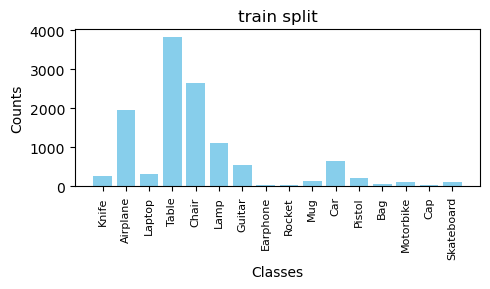

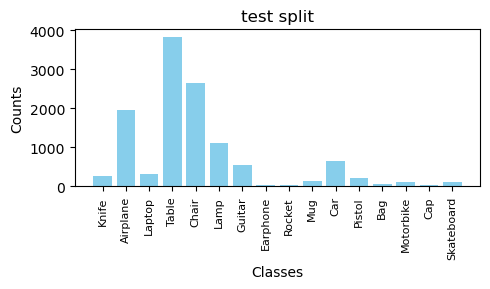

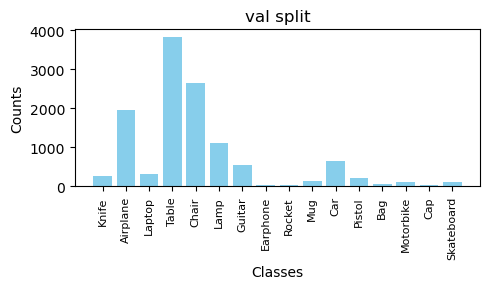

In [8]:
def plot_split_hist(split_distrib, split):
    classes = list(train_distrib.keys())
    counts = list(train_distrib.values())
    
    plt.figure(figsize=(5, 3))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes', fontsize=10)
    plt.ylabel('Counts', fontsize=10)
    plt.title(f'{split} split', fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.tight_layout()
    plt.show()

train_distrib = defaultdict(int)
test_distrib = defaultdict(int)
val_distrib = defaultdict(int)
# intra split distribution
for sample in train_split:
    train_distrib[sample[1]] += 1

for sample in test_split:
    test_distrib[sample[1]] += 1
    
for sample in val_split:
    val_distrib[sample[1]] += 1
    
train_distrib, test_distrib, val_distrib

plot_split_hist(train_distrib, 'train')
plot_split_hist(test_distrib, 'test')
plot_split_hist(val_distrib, 'val')

In [9]:
train_split_aug = train_split + test_split
output_path = os.path.join(root, dataset_name, 'train_split_aug.json')

with open(output_path, 'w') as f:
    json.dump(train_split_aug, f)
    
print(f'Saved train augmented at {output_path}')

Saved train augmented at /home/infres/lmartinez-21/.cache/kagglehub/datasets/jeremy26/shapenet-core/versions/1/Shapenetcore_benchmark/train_split_aug.json
